# Homework

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import scipy
import scipy.sparse
import scipy.sparse.linalg

1. Load the dataset

In [25]:
dt = pd.read_csv("../data/data.csv")

In [26]:
dt.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [27]:
dt.shape

(42000, 785)

In [28]:
set(dt.label.unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Convert pandas DataFrame to NumPy array

In [29]:
dt = np.array(dt)

2. Split the data in a matrix $X$ with dimensions $d \times N$ and the labels in a column vector $y$. $d = 784$

In [30]:
X = dt[:, 1:]
y = dt[:, 0]

In [31]:
X.shape

(42000, 784)

In [32]:
y.shape

(42000,)

3. Extract all the digits labeled $l$.

In [33]:
l = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

mask = [y_i in l for y_i in y] # True il the element in y is equal to l, False otherwise
y = y[mask]
X = X[mask, :]

In [34]:
X.shape

(42000, 784)

4. Split train and test

In [35]:
def train_test_split(X, y, Ntrain):
    # data = np.append(np.array([y]).T, X.T, axis=1)
    data = np.concatenate((y.reshape((-1, 1)), X.T), axis=1)
    np.random.shuffle(data)
    X_train = data[:Ntrain, 1:].T
    X_test = data[Ntrain:, 1:].T
    y_train = data[:Ntrain, 0]
    y_test = data[Ntrain:, 0]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X.T, y, int(X.shape[0] * 0.8))

In [36]:
X_train.shape

(784, 33600)

In [37]:
X_test.shape

(784, 8400)

In [38]:
def compute_class_centroids(X, y):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    return c_k

In [39]:
def convert_centroids_to_dict(labels, Z_c):
    Z_c_dict = {}
    for temp in zip(labels, Z_c.T):
        l, zc = temp
        Z_c_dict[str(l)] = zc
    return Z_c_dict

In [40]:
def PCA(X, y, k):
    c_k = compute_class_centroids(X, y)
    # Center the matrix
    cx = np.array([np.mean(col) for col in X])

    X_c = (X.T - cx).T
    
    U, _, _ = np.linalg.svd(X_c, full_matrices=False) # U_k in R^(d*k)
    U_k = U[:,:k]
    
    Z = U_k.T @ X_c
    Z_c = convert_centroids_to_dict(np.unique(y), U_k.T @ c_k.T)

    return Z, Z_c, U_k.T

In [41]:
def LDA(X, y, k):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    c = np.mean(X, axis=1)

    # Center the class matrices
    X_w = X_temp[0] - c_k[0].reshape((-1, 1))
    for i in range(1, nl):
        X_w = np.concatenate((X_w, X_temp[i] - c_k[i].reshape((-1, 1))), axis=1)

    # Compute S_w
    S_w = X_w @ X_w.T

    # Compute S_b
    X_bar = np.repeat(c_k[0].reshape((-1, 1)), X_temp[0].shape[1], axis=1)
    for i in range(1, nl):
        X_bar_i = np.repeat(c_k[i].reshape((-1, 1)), X_temp[i].shape[1], axis=1)
        X_bar = np.concatenate((X_bar, X_bar_i), axis=1)
    X_barc = X_bar - c.reshape((-1, 1))
    S_b = X_barc @ X_barc.T

    try:
        L = np.linalg.cholesky(S_w)
    except LinAlgError:    
        # Create a matrix to correct S_w to make it positive definite
        eps = 1e-6
        I_eps = np.eye(S_w.shape[0]) * eps
        S_w = S_w + I_eps
        # Decomposition
        L = np.linalg.cholesky(S_w)

    # Compute W
    L_inv = np.linalg.inv(L)
    eig_val, W = scipy.sparse.linalg.eigs(L_inv @ S_b @ L, k=k)
    W = np.real(W)

    # Compute Q.T
    Q_t = (L_inv.T @ W).T

    # Compute the projection of our data
    Z = Q_t @ X
    # and the centroid
    Z_c = convert_centroids_to_dict(labels, Q_t @ c_k.T)

    return Z, Q_t, Z_c

In [42]:
def get_intra_cluster_dists(Z, Z_c, y):
    # Compute mean distance of the point in a cluster with the centroid
    intra_dists = {}
    for cluster, coord in Z_c.items():
        cluster_points = Z[:, y==int(cluster)]
        intra_dists[cluster] = np.mean(np.array([np.linalg.norm(x - Z_c[cluster]) for x in cluster_points.T]))
    return intra_dists

In [43]:
Z_LDA, Q_t, Z_LDA_c = LDA(X_train, y_train, 2)
Z_LDA.shape, Z_LDA_c

((2, 33600),
 {'0': array([-0.02555769,  0.00042224]),
  '1': array([0.01266951, 0.01791839]),
  '2': array([-0.00360299,  0.01082963]),
  '3': array([-0.00275106,  0.0095551 ]),
  '4': array([ 0.0058335 , -0.01086505]),
  '5': array([-0.00655973,  0.00350332]),
  '6': array([-0.00765921,  0.00191623]),
  '7': array([ 0.00906229, -0.0134141 ]),
  '8': array([-0.00104968,  0.00642145]),
  '9': array([ 0.00842284, -0.01208913])})

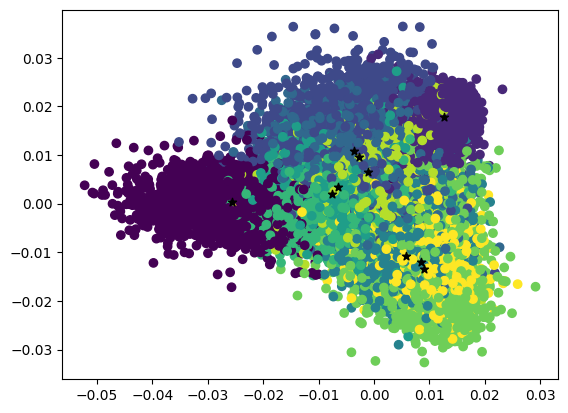

In [44]:
plt.scatter(Z_LDA[0, :], Z_LDA[1, :], c=y_train)
for key, val in Z_LDA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [45]:
print(get_intra_cluster_dists(Z_LDA, Z_LDA_c, y_train))

{'0': 0.007261556883020177, '1': 0.0042419295606431874, '2': 0.008293513999330902, '3': 0.006553386740401421, '4': 0.005537649604914469, '5': 0.005965009627856096, '6': 0.006259288132680139, '7': 0.007153263367090341, '8': 0.00665298883278619, '9': 0.005731665049085508}


In [46]:
Z_PCA, Z_PCA_c, U_kt = PCA(X_train, y_train, 2)
Z_PCA.shape, Z_PCA_c

((2, 33600),
 {'0': array([-1775.59865575,   139.04680555]),
  '1': array([ 71.31009947, 451.3988347 ]),
  '2': array([-870.1895485 ,  313.05737982]),
  '3': array([-835.82815602,  447.54417703]),
  '4': array([-669.98671191, -573.09575747]),
  '5': array([-877.22888102,  137.31010258]),
  '6': array([-943.90404411,  -16.58367437]),
  '7': array([-479.20178032, -585.43813273]),
  '8': array([-770.96286685,  186.62123769]),
  '9': array([-579.37079457, -572.93441558])})

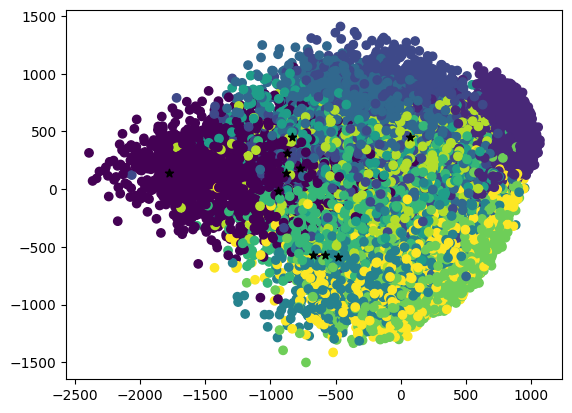

In [47]:
plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=y_train)
for key, val in Z_PCA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [48]:
print(get_intra_cluster_dists(Z_PCA, Z_PCA_c, y_train))

{'0': 820.3657199002421, '1': 795.4491428457828, '2': 858.0275056367857, '3': 841.371170229064, '4': 825.7248445027693, '5': 849.7918607194497, '6': 833.4951338770509, '7': 836.8755573904058, '8': 840.671711698596, '9': 841.0828937972675}


Compute the distance from the centroids on the test set

In [49]:
Z_LDA_test = Q_t @ X_test
get_intra_cluster_dists(Z_LDA_test, Z_LDA_c, y_test)

{'0': 0.0072264250080096406,
 '1': 0.0042732576657482065,
 '2': 0.008597499033699281,
 '3': 0.007102442503230064,
 '4': 0.005742192912448839,
 '5': 0.006000681515889547,
 '6': 0.006489204677299454,
 '7': 0.007586209900772485,
 '8': 0.006775984191848947,
 '9': 0.005891886066514609}

In [50]:
# Center the matrix
X_test_centered = np.array([np.mean(col) for col in X_test])
X_test_centered = (X_test.T - X_test_centered).T

Z_PCA_test = U_kt @ X_test_centered
get_intra_cluster_dists(Z_PCA_test, Z_PCA_c, y_test)

{'0': 823.1700424069908,
 '1': 791.5118387349779,
 '2': 863.3730831556422,
 '3': 833.3868710425776,
 '4': 821.7582570307558,
 '5': 869.6309003081129,
 '6': 811.6728950453331,
 '7': 844.9230266680794,
 '8': 855.342760041837,
 '9': 824.1109489893055}

### Build a classifier using PCA and LDA

In [51]:
def find_nearest_centroid(point, centroid_dict):
    distance_v = []
    labels = []
    for k in centroid_dict.keys():
        distance_v.append(np.linalg.norm(centroid_dict[k] - point))
        labels.append(k)
    
    return int(labels[distance_v.index(min(distance_v))])

In [52]:
def generic_classifier(Z_c, T_matrix, X_test):
    Z = T_matrix @ X_test
    # Find the nearest centroid
    y_predicted = []
    for point in Z.T:
        y_predicted.append(find_nearest_centroid(point, Z_c))
    
    return np.array(y_predicted)

In [53]:
def PCA_classifier(X_train, y_train, X_test, k=2):
    _, Z_PCA_c, U_kt = PCA(X_train, y_train, k=k)
    # Center the matrix
    X_test_centered = np.array([np.mean(col) for col in X_test])
    X_test_centered = (X_test.T - X_test_centered).T    
    return generic_classifier(Z_PCA_c, U_kt, X_test_centered)

In [54]:
def LDA_classifier(X_train, y_train, X_test, k=2):
    _, Q_t, Z_LDA_c = LDA(X_train, y_train, k=k)
    return generic_classifier(Z_LDA_c, Q_t, X_test)

In [55]:
def compute_accuracy(y_true, y_guess):
    return (len(y_true) - np.count_nonzero(y_true - y_guess)) / len(y_true) * 100

In [56]:
for k in range(2, 30, 2):
    y_predicted = PCA_classifier(X_train, y_train, X_test, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(y_test, y_predicted)) + " %")

acc with k = 2: 24.773809523809522 %
acc with k = 4: 34.98809523809524 %
acc with k = 6: 36.76190476190476 %
acc with k = 8: 43.857142857142854 %
acc with k = 10: 47.023809523809526 %
acc with k = 12: 48.07142857142857 %
acc with k = 14: 49.22619047619048 %
acc with k = 16: 51.476190476190474 %
acc with k = 18: 52.89285714285714 %
acc with k = 20: 53.761904761904766 %
acc with k = 22: 54.107142857142854 %
acc with k = 24: 54.41666666666667 %
acc with k = 26: 54.69047619047619 %
acc with k = 28: 54.84523809523809 %


In [57]:
for k in range(1, 9, 1):
    y_predicted = LDA_classifier(X_train, y_train, X_test, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(y_test, y_predicted)) + " %")

acc with k = 1: 36.41666666666667 %
acc with k = 2: 48.97619047619048 %
acc with k = 3: 72.61904761904762 %
acc with k = 4: 75.91666666666667 %
acc with k = 5: 81.82142857142857 %
acc with k = 6: 83.9047619047619 %
acc with k = 7: 84.17857142857143 %
acc with k = 8: 86.09523809523809 %


## Visualizing a dyad

In [58]:
import skimage.data
from skimage import color

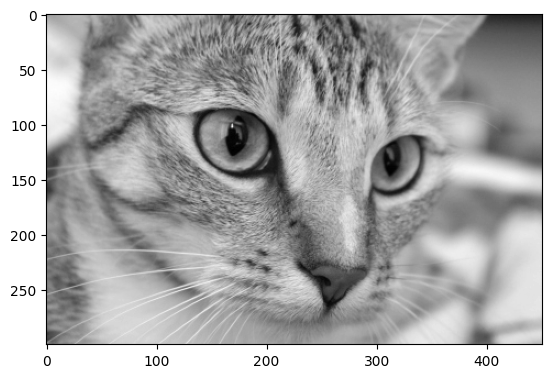

In [59]:
X = skimage.data.cat()
X = color.rgb2gray(X)
plt.imshow(X, cmap="gray")
plt.show()

In [60]:
# Compute SVD
svd_m = np.linalg.svd(X, full_matrices=False)

In [61]:
U, s, v = svd_m
U.shape, s.shape, v.shape

((300, 300), (300,), (300, 451))

In [62]:
def get_ith_dyad(i, svd_m):
    U, s, v = svd_m
    return s[i] * (U[:, i].reshape((-1, 1)) @ v[i, :].reshape((1, -1)))

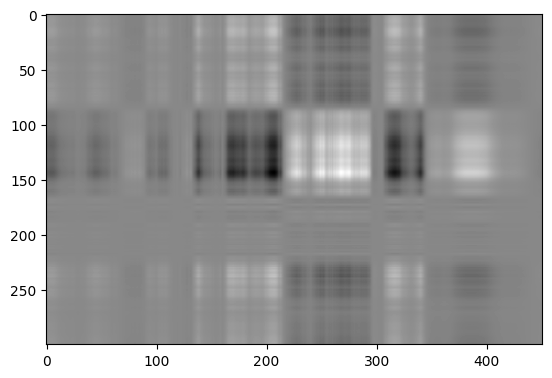

In [63]:
plt.imshow(get_ith_dyad(2, svd_m), cmap="gray")
plt.show()

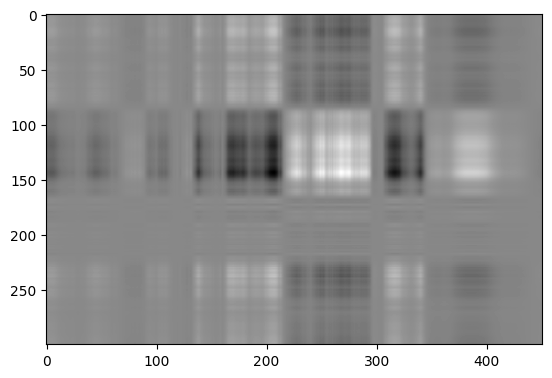

In [64]:
plt.imshow(get_ith_dyad(2, svd_m), cmap="gray")
plt.show()

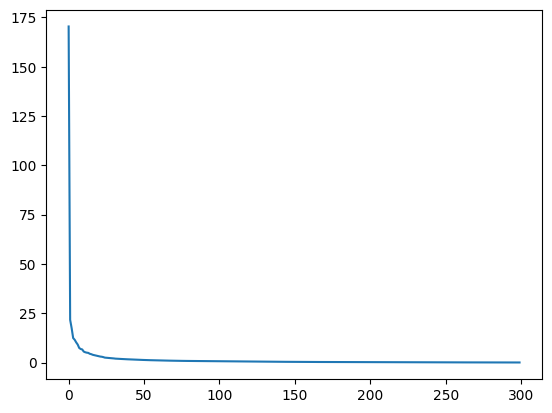

In [65]:
plt.plot(s)
plt.show()

In [66]:
def k_val_image_approximation(img, k):
    # Compute SVD
    svd_m = np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
    app_img = get_ith_dyad(0, svd_m)
    for i in range(1, k-1):
        app_img = app_img + get_ith_dyad(i, svd_m)
    return app_img

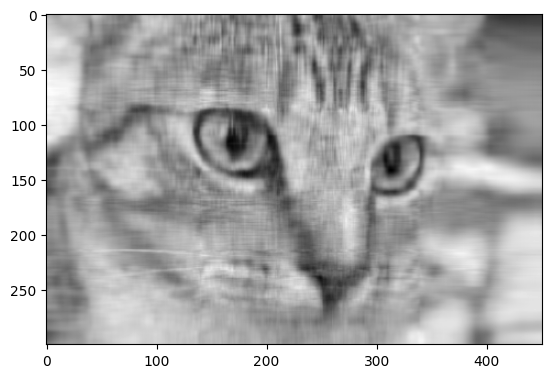

In [85]:
plt.imshow(k_val_image_approximation(X, 20), cmap="gray")
plt.show()

In [80]:
approx_range = range(1, 200, 2)
approx_error = [np.linalg.norm(X - k_val_image_approximation(X, k)) for k in approx_range]

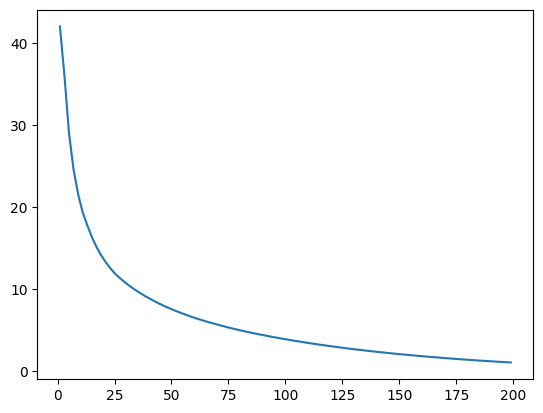

In [81]:
plt.plot([k for k in approx_range], approx_error)
plt.show()

In [82]:
compression_factor = [k/(X.shape[0] * X.shape[1]) for k in approx_range]

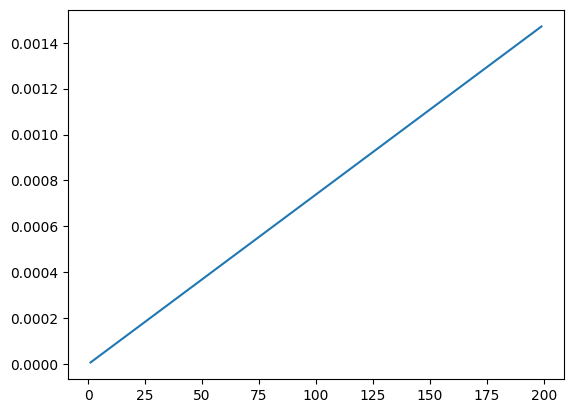

In [83]:
plt.plot([k for k in approx_range], compression_factor)
plt.show()